In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
actions = [
    'rock_paper', 
    'shaking_hands', 
    'moving_fingers', 
    'opp_rock_paper', 
    'clap', 
    'finger_clap', 
    'rock_clap', 
    'count_number'
]

data = np.concatenate([
    np.load('dataset/seq_rock_paper_1698065803.npy'),
    np.load('dataset/seq_shaking_hands_1698065803.npy'),
    np.load('dataset/seq_moving_fingers_1698065803.npy'),
    np.load('dataset/seq_opp_rock_paper_1698065803.npy'),
    np.load('dataset/seq_clap_1698065803.npy'),
    np.load('dataset/seq_finger_clap_1698065803.npy'),
    np.load('dataset/seq_rock_clap_1698065803.npy'),
    np.load('dataset/seq_count_number_1698065803.npy')
], axis=0)

data.shape

(6383, 30, 100)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(6383, 30, 99)
(6383,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(6383, 8)

In [6]:
from sklearn.model_selection import train_test_split  #트레이닝셋과 테스트셋 나눔 

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5744, 30, 99) (5744, 8)
(639, 30, 99) (639, 8)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 44328 (173.16 KB)
Trainable params: 44328 (173.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
174/180 [============================>.] - ETA: 0s - loss: 20.5689 - acc: 0.2890
Epoch 1: val_acc improved from -inf to 0.37089, saving model to models/model.h5
180/180 [==============================] - 2s 8ms/step - loss: 20.1972 - acc: 0.2916 - val_loss: 10.4443 - val_acc: 0.3709 - lr: 0.0010
Epoch 2/200
 22/180 [==>...........................] - ETA: 1s - loss: 10.8845 - acc: 0.3636

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/180 [============================>.] - ETA: 0s - loss: 7.0722 - acc: 0.3918
Epoch 2: val_acc improved from 0.37089 to 0.53208, saving model to models/model.h5
180/180 [==============================] - 1s 8ms/step - loss: 7.0570 - acc: 0.3919 - val_loss: 3.1858 - val_acc: 0.5321 - lr: 0.0010
Epoch 3/200
175/180 [============================>.] - ETA: 0s - loss: 2.3788 - acc: 0.5766
Epoch 3: val_acc improved from 0.53208 to 0.68232, saving model to models/model.h5
180/180 [==============================] - 1s 8ms/step - loss: 2.3599 - acc: 0.5794 - val_loss: 1.8560 - val_acc: 0.6823 - lr: 0.0010
Epoch 4/200
175/180 [============================>.] - ETA: 0s - loss: 1.5162 - acc: 0.6812
Epoch 4: val_acc improved from 0.68232 to 0.69640, saving model to models/model.h5
180/180 [==============================] - 1s 8ms/step - loss: 1.5159 - acc: 0.6804 - val_loss: 1.4429 - val_acc: 0.6964 - lr: 0.0010
Epoch 5/200
179/180 [============================>.] - ETA: 0s - loss: 2.3508 - acc: 

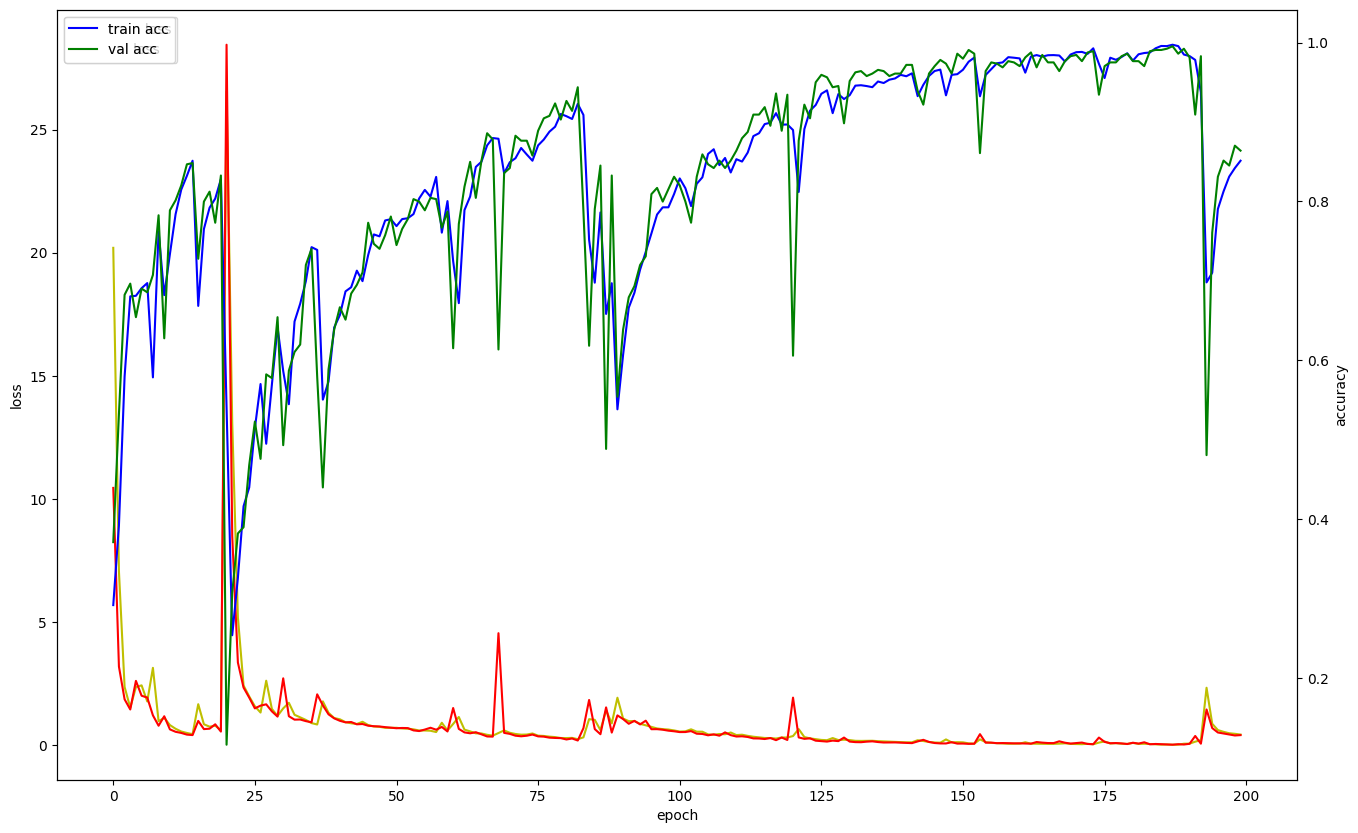

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

20/20 [==============================] - 0s 4ms/step


array([[[551,   0],
        [  1,  87]],

       [[549,   0],
        [  1,  89]],

       [[560,   0],
        [  0,  79]],

       [[543,   0],
        [  0,  96]],

       [[595,   1],
        [  0,  43]],

       [[555,   1],
        [  0,  83]],

       [[570,   1],
        [  0,  68]],

       [[547,   0],
        [  1,  91]]])